## Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1. Create your own dataset featuring 3 custom categories of at least 100 images each

My dataset contains three categories: 1. Cars, 2. Dogs, 3. Tables of more than 100 images in each category

In [ ]:
data_dir1="/content/drive/My Drive/dataset"

In [ ]:
data_dir = pathlib.Path(data_dir1)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

335


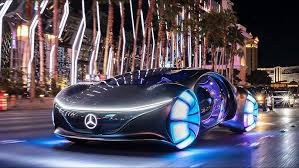

In [ ]:
car = list(data_dir.glob('car/*'))
PIL.Image.open(str(car[0]))

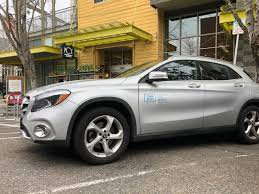

In [ ]:
PIL.Image.open(str(car[1]))

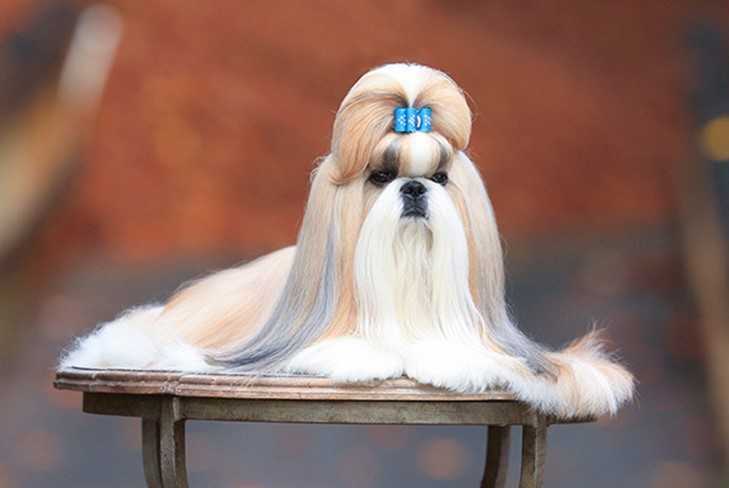

In [ ]:
dogs = list(data_dir.glob('dogs/*'))
PIL.Image.open(str(dogs[0]))

## Load using keras.preprocessing

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

## Step 2. Split this data between 80% training and 20% test

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 335 files belonging to 3 classes.
Using 268 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 335 files belonging to 3 classes.
Using 67 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['car', 'dogs', 'table']


Visualize the data

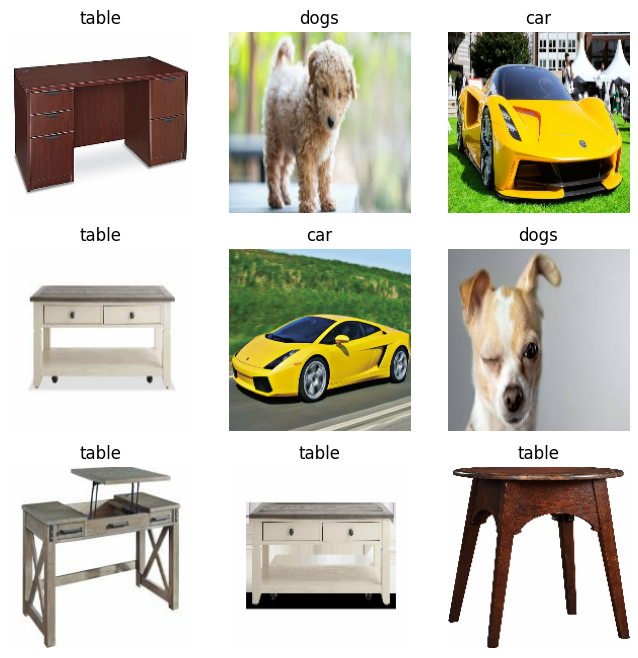

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Step 3. Preprocess the data as you see fit

## Autotuning the model

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardizing the data

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Step 4. Create a Convolutional Neural Network based model to learn on your training set

In [ ]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

## Training the model

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
9/9 [==============================] - 10s 1s/step - loss: 0.1732 - accuracy: 0.9478 - val_loss: 0.9612 - val_accuracy: 0.7313
Epoch 2/5
9/9 [==============================] - 11s 1s/step - loss: 0.2163 - accuracy: 0.9179 - val_loss: 0.8784 - val_accuracy: 0.7463
Epoch 3/5
9/9 [==============================] - 12s 1s/step - loss: 0.1559 - accuracy: 0.9366 - val_loss: 0.7513 - val_accuracy: 0.8657
Epoch 4/5
9/9 [==============================] - 9s 1s/step - loss: 0.1645 - accuracy: 0.9254 - val_loss: 0.7311 - val_accuracy: 0.8358
Epoch 5/5
9/9 [==============================] - 12s 1s/step - loss: 0.1403 - accuracy: 0.9478 - val_loss: 0.6541 - val_accuracy: 0.8358


## Visualize training data and model

Final Training Accuracy: 0.9478
Final Validation Accuracy: 0.8358


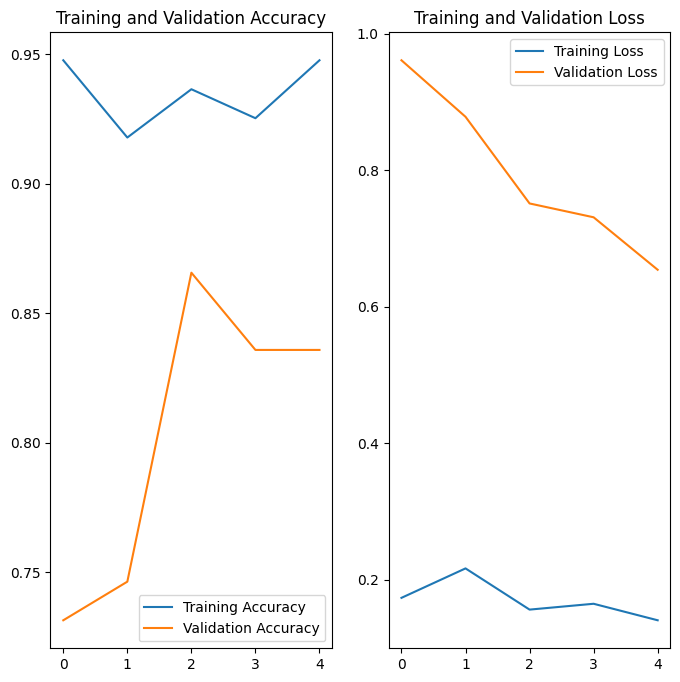

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Calculate and print the final training and validation accuracies
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
print(f'Final Training Accuracy: {final_train_acc:.4f}')
print(f'Final Validation Accuracy: {final_val_acc:.4f}')

pltt.show()

##Result for model (without augmentation, dropout rate)

#### The  Training Accuracy: 0.94, and the Validation Accuracy: 0.83

## Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

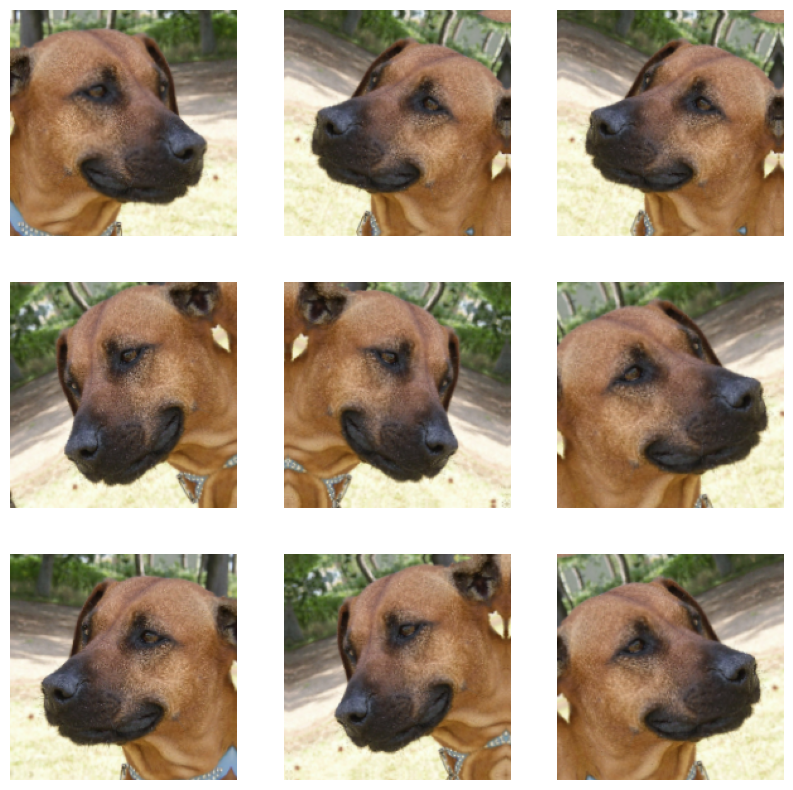

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
9/9 [==============================] - 13s 1s/step - loss: 0.1247 - accuracy: 0.9440 - val_loss: 0.7410 - val_accuracy: 0.8060
Epoch 2/10
9/9 [==============================] - 12s 1s/step - loss: 0.0918 - accuracy: 0.9664 - val_loss: 0.4963 - val_accuracy: 0.9254
Epoch 3/10
9/9 [==============================] - 10s 1s/step - loss: 0.1366 - accuracy: 0.9440 - val_loss: 0.5237 - val_accuracy: 0.9104
Epoch 4/10
9/9 [==============================] - 11s 1s/step - loss: 0.1089 - accuracy: 0.9552 - val_loss: 0.6160 - val_accuracy: 0.8507
Epoch 5/10
9/9 [==============================] - 12s 1s/step - loss: 0.1256 - accuracy: 0.9440 - val_loss: 0.6009 - val_accuracy: 0.8955
Epoch 6/10
9/9 [==============================] - 10s 1s/step - loss: 0.1116 - accuracy: 0.9627 - val_loss: 0.5843 - val_accuracy: 0.9254
Epoch 7/10
9/9 [==============================] - 11s 1s/step - loss: 0.1174 - accuracy: 0.9478 - val_loss: 0.6966 - val_accuracy: 0.8806
Epoch 8/10
9/9 [==================

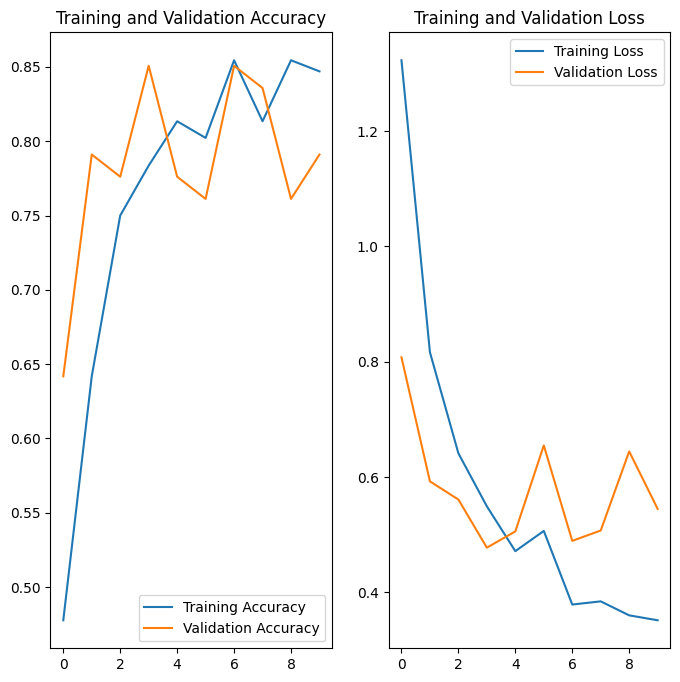

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Step 5. Make predictions on the test data and compare them to the expected categories

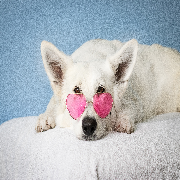

1/1 [==============================] - 0s 42ms/step
This image most likely belongs to dogs with a 56.52 percent confidence.


In [ ]:
Image_Category_Path = "/content/drive/My Drive/dog_test.jpg"

img = keras.preprocessing.image.load_img(
    Image_Category_Path, target_size=(img_height, img_width)
)

display(img)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

## Result

The made predictions on the test data are accurate according to the expected categories

## Step 6: Use GoogleNet and add a LinearLayer on top of it.

In [ ]:
from tensorflow.keras.applications import InceptionV3


base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

flatten_layer = layers.Flatten()(base_model.output)
linear_layer = layers.Dense(128, activation='relu')(flatten_layer)
output_layer = layers.Dense(num_classes)(linear_layer)

model = tf.keras.Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Step 7: Train the GoogleNet model and compare the accuracy with the first model.

Epoch 1/10
9/9 [==============================] - 34s 3s/step - loss: 223.9775 - accuracy: 0.4254 - val_loss: 49.5660 - val_accuracy: 0.7761
Epoch 2/10
9/9 [==============================] - 30s 4s/step - loss: 73.2768 - accuracy: 0.7127 - val_loss: 44.9013 - val_accuracy: 0.7313
Epoch 3/10
9/9 [==============================] - 33s 4s/step - loss: 51.0542 - accuracy: 0.7948 - val_loss: 151.1811 - val_accuracy: 0.5970
Epoch 4/10
9/9 [==============================] - 34s 4s/step - loss: 31.7772 - accuracy: 0.8769 - val_loss: 62.1494 - val_accuracy: 0.7761
Epoch 5/10
9/9 [==============================] - 24s 3s/step - loss: 21.6292 - accuracy: 0.8993 - val_loss: 72.7238 - val_accuracy: 0.7910
Epoch 6/10
9/9 [==============================] - 27s 3s/step - loss: 30.2970 - accuracy: 0.8918 - val_loss: 61.3194 - val_accuracy: 0.8060
Epoch 7/10
9/9 [==============================] - 30s 3s/step - loss: 39.0129 - accuracy: 0.8657 - val_loss: 73.8266 - val_accuracy: 0.7612
Epoch 8/10
9/9 [==

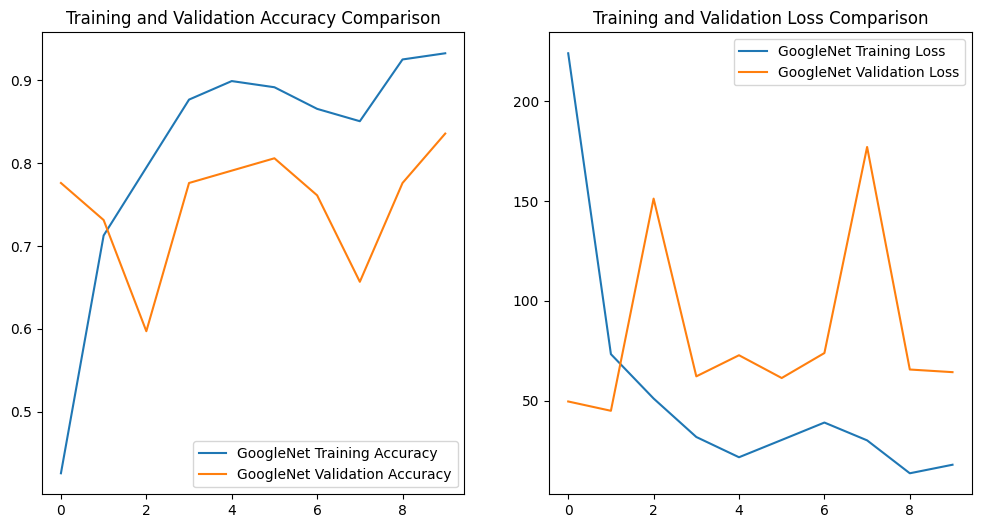

In [ ]:
# Training the GoogleNet model

history_googlenet = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Visualize training results for the GoogleNet model
acc_googlenet = history_googlenet.history['accuracy']
val_acc_googlenet = history_googlenet.history['val_accuracy']

loss_googlenet = history_googlenet.history['loss']
val_loss_googlenet = history_googlenet.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_googlenet, label='GoogleNet Training Accuracy')
plt.plot(epochs_range, val_acc_googlenet, label='GoogleNet Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Comparison')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_googlenet, label='GoogleNet Training Loss')
plt.plot(epochs_range, val_loss_googlenet, label='GoogleNet Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Comparison')

plt.show()

In [ ]:

# Calculate and print the final training and validation accuracies for GoogleNet model
final_train_acc_googlenet = acc_googlenet[-1]
final_val_acc_googlenet = val_acc_googlenet[-1]
print(f'Final GoogleNet Training Accuracy: {final_train_acc_googlenet:.4f}')
print(f'Final GoogleNet Validation Accuracy: {final_val_acc_googlenet:.4f}')

plt.show()

Final GoogleNet Training Accuracy: 0.9328
Final GoogleNet Validation Accuracy: 0.8358


## Comparison:

The CNN model gave an accuracy of 0.86 whereas the Googlenet model gave an accuracy of 0.83. Based on this it can be concluded that for the dataset i have taken CNN model performed better than the GoogleNet.